# How do interaction effects between mutations at an epitope affect `Polyclonal`? 

We assume the antibody escape fraction can be modeled as:

$$ p_v = \prod_{e=1}^{E} S(-a_{wt,e} + \sum_{m=1}^{M} \beta_{m,e} b_m) $$

where $S(.)$ is a sigmoid function.

However, what if in reality, interactions between mutations at an epitope also contribute to $p_v$, like:

$$ p_v = \prod_{e=1}^{E} S(-a_{wt,e} + \sum_{m=1}^{M} \beta_{m,e} b_m + \sum_{m < n}^{M} \beta_{mn,e} b_m b_n + \cdots) $$

Does the absence of $\beta_{mn,e}$ interaction terms lead to poorly inferred "true" individual mutation effects (i.e., $\beta_{m,e}$)? Or, are the "true" $\beta_{m,e}$ still inferred well, leaving the $a_{wt,e}$ terms to compensate for the interaction effects? In either case, I think the presence of interaction effects can lead to misinterpretation of escape mutations and wildtype epitope activities, as well as poor escape prediction. Here, I'll try and explore this through a simple simulation.

In [1]:
import random

import polyclonal
import pandas as pd
import numpy as np
import altair as alt

from plotnine import *
from sklearn.preprocessing import PolynomialFeatures
from sympy.utilities.iterables import multiset_permutations

Lets set some parameters. I'll simulate a simple DMS library containing 12 mutations. There will be 4 mutations located at each epitope, and 3 epitopes being targeted by the polyclonal serum. I'll also set the wildtype activities for each of the 3 epitopes here.

In [2]:
n = 12 # number of mutations
n_per_e = 4 # number of mutations that contribute to each epitope
n_e = 3 # number of epitopes

a_wt_1 = 3 # wildtype activity of epitope 1
a_wt_2 = 5 # wildtype activity of epitope 2
a_wt_3 = 4 # wildtype activity of epitope 3

Randomly generate some values for the individual mutation effects. These are all positive since I'm assuming all of them are beneficial to antibody escape. 

In [3]:
np.random.seed(11)
params = np.random.uniform(low=0, high=10, size=(n,))
params

array([1.80269689, 0.19475241, 4.63218526, 7.24933929, 4.20203605,
       4.85427098, 0.12780815, 4.87371607, 9.41806652, 8.50795089,
       7.2996447 , 1.08736072])

Generate an array that contains binary representations of all $2^{N}$ possible variants. This is a simulation of the variants that we have measured escape for using DMS.

In [4]:
variants = []
wt = list(np.zeros(n,).astype(int))
variants.append(wt)

for order in range(1,n+1):  
    bg_seq = wt.copy()
    for idx in range(order):
        if bg_seq[idx] == 0:
            bg_seq[idx] = 1
    
    for perm in list(multiset_permutations(bg_seq)):
        variants.append(perm)

print(f"There are {len(variants)} variants.")

There are 4096 variants.


## Simulation and model inference when there are no interactions 

Compute the "true" probability of escape for each variant given its set of mutations when there are no interaction effects between mutations. For simplicity, I will assume that the first 4 mutations affect escape from epitope 1, the next 4 mutations affect escape from epitope 2, and the last 4 mutations affect escape from epitope 3. 

In [5]:
np.random.seed(123)

def sigmoid(x):
     return 1 / (1 + np.exp(-x))

# first 4 mutations = epitope 1, next 4 mutations = epitope 2, last 4 mutations = epitope 3
# add a little gaussian noise so the data isn't perfect

e1 = sigmoid(np.matmul(np.array(variants)[:,:4], params[:4]) - a_wt_1 + np.random.normal(0, 0.05, len(variants)))
print(e1)

e2 = sigmoid(np.matmul(np.array(variants)[:,4:8], params[4:8]) - a_wt_2 + np.random.normal(0, 0.05, len(variants)))
print(e2)

e3 = sigmoid(np.matmul(np.array(variants)[:,8:], params[8:]) - a_wt_3 + np.random.normal(0, 0.05, len(variants)))
print(e3)

escape = np.prod([e1, e2, e3], axis=0)
print(escape)

[0.04503299 0.04973024 0.04806918 ... 0.9999817  0.99998234 0.99998161]
[0.00753774 0.00667314 0.0065839  ... 0.99988641 0.99988182 0.99988708]
[0.01886706 0.05211945 0.96663012 ... 0.99999968 1.         1.        ]
[6.40437083e-06 1.72961919e-05 3.05921832e-04 ... 9.99867802e-01
 9.99864161e-01 9.99868694e-01]


Visualize how probability of escape varies as a function of number of mutations.

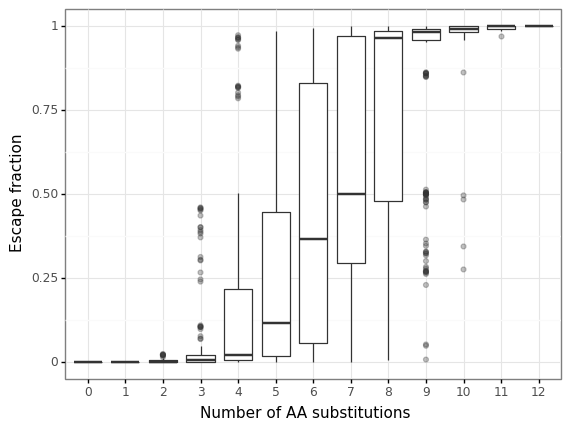

<ggplot: (8790961668741)>

In [6]:
plot_data = pd.DataFrame(
    {
        'num_aa_substitutions' : np.sum(variants, 1),
        'escape_fraction' : escape
    }
)

(
    ggplot(plot_data, aes(y = 'escape_fraction', x = 'factor(num_aa_substitutions)')) +
    geom_boxplot(outlier_alpha = 0.3) +
    theme_bw() +
    labs(x = 'Number of AA substitutions', y = 'Escape fraction')
)

Combine everything from above into a dataframe that can be passed into `Polyclonal`.

In [7]:
# mutation names are not significant, just something to make the simulation easy
muts = ['M1A', 'M2A', 'M3A', 'M4A', 'M5A', 'M6A',
        'M7A', 'M8A', 'M9A', 'M10A', 'M11A', 'M12A']

var_strings = []
for var in variants:
    var_lst = []
    for idx,i in enumerate(var):
        if i == 1:
            var_lst.append(muts[idx])
            
    var_strings.append(' '.join(var_lst))

data = pd.DataFrame(
    {
        'library' : ['lib1'] * len(variants),
        'name' : ['simulated_sera'] * len(variants),
        'aa_substitutions' : var_strings,
        'n_aa_substitutions' : np.sum(variants, 1),
        'prob_escape' : escape,
        'concentration' : [1] * len(variants)   
    }
)
data

,library,name,aa_substitutions,n_aa_substitutions,prob_escape,concentration
0,lib1,simulated_sera,,0,0.000006,1
1,lib1,simulated_sera,M12A,1,0.000017,1
2,lib1,simulated_sera,M11A,1,0.000306,1
3,lib1,simulated_sera,M10A,1,0.000268,1
4,lib1,simulated_sera,M9A,1,0.000301,1
...,...,...,...,...,...,...
4091,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M10A M11A M12A,11,0.999873,1
4092,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M11A M12A,11,0.999865,1
4093,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M10A M12A,11,0.999868,1
4094,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M10A M11A,11,0.999864,1


Randomly split the data into a training set (80%) and test set (20%).

In [8]:
train_data = data.sample(frac = 0.8, random_state = 1)
print(f"There are {len(train_data)} sequences in the training dataset.")

train_data_idx = train_data.index
test_data = data.drop(train_data_idx)
print(f"There are {len(test_data)} sequences in the test dataset.")

There are 3277 sequences in the training dataset.
There are 819 sequences in the test dataset.


Fit a `Polyclonal` model to the training set with three epitopes.

In [9]:
poly_abs = polyclonal.Polyclonal(
    data_to_fit=train_data,
    n_epitopes=3,
)

opt_res = poly_abs.fit(logfreq=200)

# First fitting site-level model.
# Starting optimization of 39 parameters at Sat Feb 26 00:11:05 2022.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0  0.0064096     1113.8     1113.8          0          0
        200    0.89349     1.2373    0.71239    0.52488          0
        379     1.5897     1.2053    0.68146    0.52382          0
# Successfully finished at Sat Feb 26 00:11:07 2022.
# Starting optimization of 39 parameters at Sat Feb 26 00:11:07 2022.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0     0.0044     1.2053    0.68146    0.52382          0
          2   0.013671     1.2053    0.68146    0.52382          0
# Successfully finished at Sat Feb 26 00:11:07 2022.


Harmonize the fit epitopes with the true epitopes. This is because the epitope numbering is arbitrary, and we want to compare the fit coefficients to the actual coefficients.

In [10]:
e1_params = np.concatenate([params[:4], np.zeros(8)])
e2_params = np.concatenate([np.zeros(4), params[4:8], np.zeros(4)])
e3_params = np.concatenate([np.zeros(8), params[8:]])

ref_df = (
        poly_abs.mut_escape_df
        .assign(escape = np.concatenate([e1_params, e2_params, e3_params]))
)

ref_poly_abs = polyclonal.Polyclonal(
    activity_wt_df=pd.DataFrame(
        {
            'epitope' : ['1', '2', '3'],
            'activity' : [a_wt_1, a_wt_2, a_wt_3]
        }
    ), 
    mut_escape_df=ref_df
)
        
poly_abs.harmonize_epitopes_with(ref_poly_abs)

Plot the correlation between predicted and actual probability of escape. Note that this correlation is extremely strong, which is expected as the probability of escape values were generated under the exact same assumptions as `Polyclonal`.

R2: 1.0


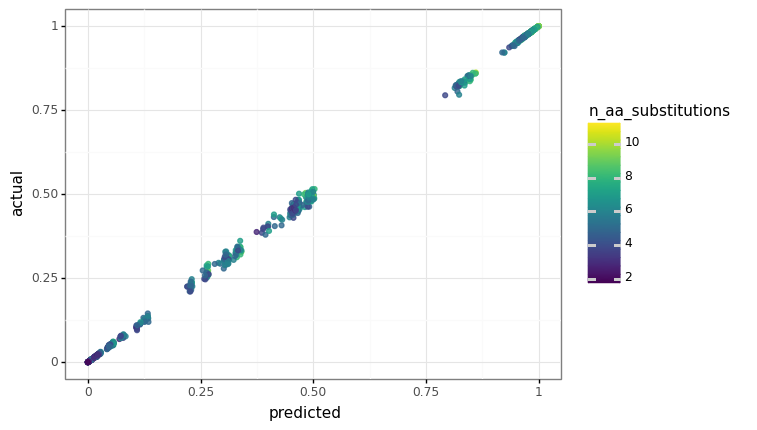

<ggplot: (8790959340307)>

In [11]:
plot_data = (
    poly_abs.prob_escape(variants_df=test_data)
            .rename(columns={"prob_escape": "actual", 
                             "predicted_prob_escape": "predicted"})
)

r2 = plot_data["actual"].corr(plot_data["predicted"]) ** 2
print(f"R2: {r2.round(3)}")
        
(
    ggplot(plot_data, aes(x = 'predicted', y = 'actual')) +
    geom_point(aes(color = 'n_aa_substitutions'), alpha=0.8) +
    theme_bw()
)

Also plot the wildtype activity coefficients, which also match up as expected.

In [12]:
poly_abs.activity_wt_barplot()

alt.Chart(...)

Lastly, plot the mutation effect coefficients. We can see that they match up well too, as expected. 

In [13]:
plot_data = pd.merge(
    poly_abs.mut_escape_df.rename(columns={"escape": "predicted"}), 
    ref_df.rename(columns={"escape": "true"}), 
    on=['epitope', 'site', 'wildtype', 'mutant', 'mutation']
).melt(id_vars = ['epitope', 'site', 'wildtype', 'mutant', 'mutation'])

domain = list(poly_abs.epitope_colors.keys())
rnge = list(poly_abs.epitope_colors.values())

alt.Chart(plot_data).mark_bar().encode(
    y=alt.Y('variable', title = None),
    x=alt.X('value', title = 'beta coefficient'),
    color=alt.Color('epitope', scale = alt.Scale(domain=domain, range=rnge)),
    row=alt.Row('mutation', sort=alt.SortField(field='site')),
    column ='epitope',
    tooltip=['epitope', 'site', 'wildtype', 'mutant', 'variable', 'value']
).properties(height = 25, width = 225)

alt.Chart(...)

## Simulation and model inference when there are pairwise interactions

We'll use the same individual mutation effects as above. Now, we'll also randomly generate some values for the pairwise interaction mutation effects (between mutations at the same epitope).

In [14]:
np.random.seed(22)
interact_params = np.random.normal(loc=0, scale=1, size=(int(n_per_e*(n_per_e-1)/2) * n_e,))
#interact_params = np.zeros((int(n_per_e*(n_per_e-1)/2) * n_e,))
interact_params

array([-0.09194992, -1.46335065,  1.08179168, -0.23932517, -0.49112914,
       -1.00227201,  0.9188215 , -1.1036321 ,  0.62649346, -0.56151378,
        0.02885512, -0.23076719,  0.58775221,  0.75231758, -1.05850255,
        1.05597241,  0.74775027,  1.06467659])

Now, lets re-compute the probability of escape values for each variant under the assumption that there are pairwise interactions between mutations.

In [15]:
np.random.seed(123)

poly = PolynomialFeatures(2, interaction_only=True)

def sigmoid(x):
     return 1 / (1 + np.exp(-x))

e1 = sigmoid(
        np.matmul(
            poly.fit_transform(np.array(variants)[:,:4])[:,1:], np.append(params[:4], interact_params[:6])
        ) - a_wt_1 + np.random.normal(0, 0.05, len(variants)
    )
)
print(e1)

e2 = sigmoid(
        np.matmul(
            poly.fit_transform(np.array(variants)[:,4:8])[:,1:], np.append(params[4:8], interact_params[6:12])
        ) - a_wt_2 + np.random.normal(0, 0.05, len(variants)
    )
)
print(e2)

e3 = sigmoid(
        np.matmul(
            poly.fit_transform(np.array(variants)[:,8:])[:,1:], np.append(params[8:], interact_params[12:])
        ) - a_wt_3 + np.random.normal(0, 0.05, len(variants)
    )
)
print(e3)

escape_interact = np.prod([e1, e2, e3], axis=0)
print(escape_interact)

[0.04503299 0.04973024 0.04806918 ... 0.99983386 0.99983963 0.999833  ]
[0.00753774 0.00667314 0.0065839  ... 0.99984331 0.99983698 0.99984424]
[0.01886706 0.05211945 0.96663012 ... 0.99999976 1.         1.        ]
[6.40437083e-06 1.72961919e-05 3.05921832e-04 ... 9.99676955e-01
 9.99676634e-01 9.99677264e-01]


Visualize how probability of escape varies as a function of number of mutations.

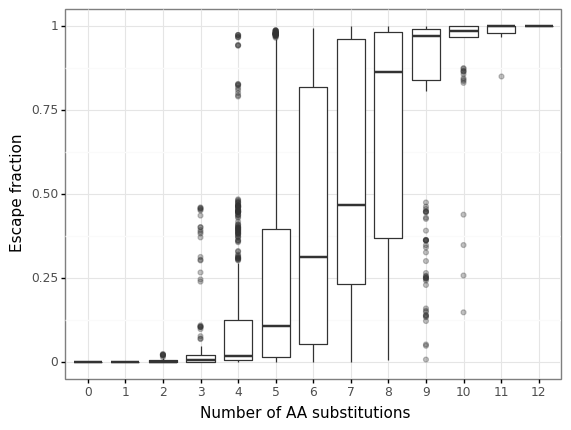

<ggplot: (8790959296509)>

In [16]:
plot_data = pd.DataFrame(
    {
        'num_aa_substitutions' : np.sum(variants, 1),
        'escape_fraction' : escape_interact
    }
)

(
    ggplot(plot_data, aes(y = 'escape_fraction', x = 'factor(num_aa_substitutions)')) +
    geom_boxplot(outlier_alpha = 0.3) +
    theme_bw() +
    labs(x = 'Number of AA substitutions', y = 'Escape fraction')
)

Combine everything from above into a dataframe that can be passed into `Polyclonal`.

In [17]:
muts = ['M1A', 'M2A', 'M3A', 'M4A', 'M5A', 'M6A',
        'M7A', 'M8A', 'M9A', 'M10A', 'M11A', 'M12A']

var_strings = []
for var in variants:
    var_lst = []
    for idx,i in enumerate(var):
        if i == 1:
            var_lst.append(muts[idx])
            
    var_strings.append(' '.join(var_lst))

data = pd.DataFrame(
    {
        'library' : ['lib1'] * len(variants),
        'name' : ['simulated_sera'] * len(variants),
        'aa_substitutions' : var_strings,
        'n_aa_substitutions' : np.sum(variants, 1),
        'prob_escape' : escape_interact,
        'concentration' : [1] * len(variants),
        'epistatic_effect': np.abs(escape_interact - escape)
    }
)
data

,library,name,aa_substitutions,n_aa_substitutions,prob_escape,concentration,epistatic_effect
0,lib1,simulated_sera,,0,0.000006,1,0.000000
1,lib1,simulated_sera,M12A,1,0.000017,1,0.000000
2,lib1,simulated_sera,M11A,1,0.000306,1,0.000000
3,lib1,simulated_sera,M10A,1,0.000268,1,0.000000
4,lib1,simulated_sera,M9A,1,0.000301,1,0.000000
...,...,...,...,...,...,...,...
4091,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M10A M11A M12A,11,0.999690,1,0.000184
4092,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M11A M12A,11,0.999664,1,0.000201
4093,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M10A M12A,11,0.999677,1,0.000191
4094,lib1,simulated_sera,M1A M2A M3A M4A M5A M6A M7A M8A M9A M10A M11A,11,0.999677,1,0.000188


Randomly split the data into a training set (80%) and test set (20%).

In [18]:
train_data = data.sample(frac = 0.8, random_state = 1)
print(f"There are {len(train_data)} sequences in the training dataset.")

train_data_idx = train_data.index
test_data = data.drop(train_data_idx)
print(f"There are {len(test_data)} sequences in the test dataset.")

There are 3277 sequences in the training dataset.
There are 819 sequences in the test dataset.


Fit a `Polyclonal` model to the training set with three epitopes.

In [19]:
poly_abs = polyclonal.Polyclonal(
    data_to_fit=train_data,
    n_epitopes=3,
)

opt_res = poly_abs.fit(logfreq=200)

# First fitting site-level model.
# Starting optimization of 39 parameters at Sat Feb 26 00:11:09 2022.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0  0.0058429     1035.8     1035.8          0          0
        200      0.858     11.133     10.379    0.75443          0
        400     1.6859     10.807     10.127     0.6798          0
        600     2.5433     9.7814      9.258    0.52344          0
        656     2.7663     9.7805     9.2561    0.52441          0
# Successfully finished at Sat Feb 26 00:11:12 2022.
# Starting optimization of 39 parameters at Sat Feb 26 00:11:12 2022.
       step   time_sec       loss   fit_loss reg_escape  regspread
          0  0.0048862     9.7805     9.2561    0.52441          0
          2   0.014824     9.7805     9.2561    0.52441          0
# Successfully finished at Sat Feb 26 00:11:12 2022.


Harmonize the fit epitopes with the true epitopes. 

In [20]:
e1_params = np.concatenate([params[:4], np.zeros(8)])
e2_params = np.concatenate([np.zeros(4), params[4:8], np.zeros(4)])
e3_params = np.concatenate([np.zeros(8), params[8:]])

ref_df = (
        poly_abs.mut_escape_df
        .assign(escape = np.concatenate([e1_params, e2_params, e3_params]))
)

ref_poly_abs = polyclonal.Polyclonal(
    activity_wt_df=pd.DataFrame(
        {
            'epitope' : ['1', '2', '3'],
            'activity' : [a_wt_1, a_wt_2, a_wt_3]
        }
    ), 
    mut_escape_df=ref_df
)
        
poly_abs.harmonize_epitopes_with(ref_poly_abs)

Plot the correlation between predicted and actual probability of escape. The correlation is still quite strong, but notice how there is a cluster of variants that are now big outliers (over-predicted probability of escape). These variants also have large "epistatic effects," calculated as the absolute value of the difference between the escape fraction with no interactions and escape fraction with pairwise interactions.

R2: 0.66


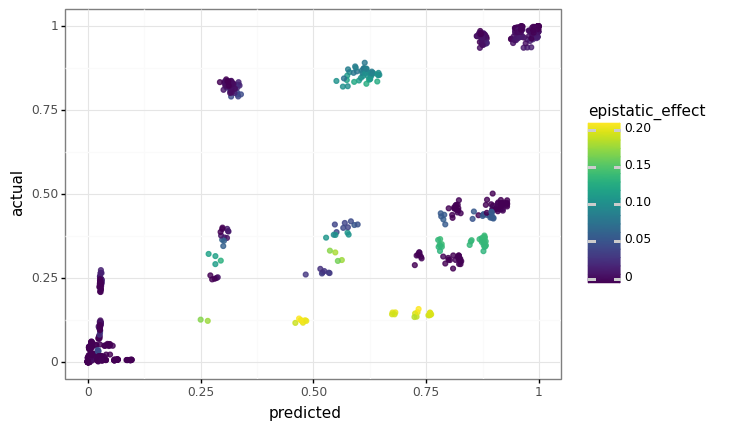

<ggplot: (8790959436072)>

In [21]:
plot_data = (
    poly_abs.prob_escape(variants_df=test_data)
            .rename(columns={"prob_escape": "actual", 
                             "predicted_prob_escape": "predicted"})
)

r2 = plot_data["actual"].corr(plot_data["predicted"]) ** 2
print(f"R2: {r2.round(3)}")
        
(
    ggplot(plot_data, aes(x = 'predicted', y = 'actual')) +
    geom_point(aes(color = 'epistatic_effect'), alpha=0.8) +
    theme_bw()
)

Also plot the wildtype activity coefficients, which no longer match up with what was expected.

In [22]:
poly_abs.activity_wt_barplot()

alt.Chart(...)

Lastly, plot the mutation effect coefficients. Surprisingly, these have been preserved to some degree. Although there are some exceptions, with some mutations being misinterpreted as being individually deleterious to escape, when they are actually individually beneficial to escape, but have a negative epistatic interaction when together with another mutation.

In [23]:
plot_data = pd.merge(
    poly_abs.mut_escape_df.rename(columns={"escape": "predicted"}), 
    ref_df.rename(columns={"escape": "true"}), 
    on=['epitope', 'site', 'wildtype', 'mutant', 'mutation']
).melt(id_vars = ['epitope', 'site', 'wildtype', 'mutant', 'mutation'])

domain = list(poly_abs.epitope_colors.keys())
rnge = list(poly_abs.epitope_colors.values())

alt.Chart(plot_data).mark_bar().encode(
    y=alt.Y('variable', title = None),
    x=alt.X('value', title = 'beta coefficient'),
    color=alt.Color('epitope', scale = alt.Scale(domain=domain, range=rnge)),
    row=alt.Row('mutation', sort=alt.SortField(field='site')),
    column ='epitope',
    tooltip=['epitope', 'site', 'wildtype', 'mutant', 'variable', 'value']
).properties(height = 25, width = 225)

alt.Chart(...)

Overall, I think this simulation suggests that epistatic interactions are worth thinking about. Optimistically, we should be able to tell if epistatic interactions are a problem from a poor out-of-sample escape prediction. However, the question of how to add interactions to `Polyclonal` isn't trivial, as there are so many possible pairwise interactions in multi-mutant DMS. 

In [24]:
!jupyter nbconvert interaction_effects.ipynb --to HTML

[NbConvertApp] Converting notebook interaction_effects.ipynb to HTML
[NbConvertApp] Writing 863402 bytes to interaction_effects.html
